In [1]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


In [2]:
EXAMPLE_ROOT = 'Example03'
LFW_HOME = f'{EXAMPLE_ROOT}/lfw_home'
LFW_FUNNELED = f'{LFW_HOME}/lfw_funneled'

import shutil, os

# clear joblib cache
JOBLIB_CACHE= f'{LFW_HOME}/joblib'
if (os.path.isdir(JOBLIB_CACHE)):
    shutil.rmtree(JOBLIB_CACHE)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.196s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.041s
Fitting the classifier to the training set
done in 42.935s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.066s
                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.54      0.61        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.85      0.98      0.91       146
Gerhard Schroeder       0.95      0.80  

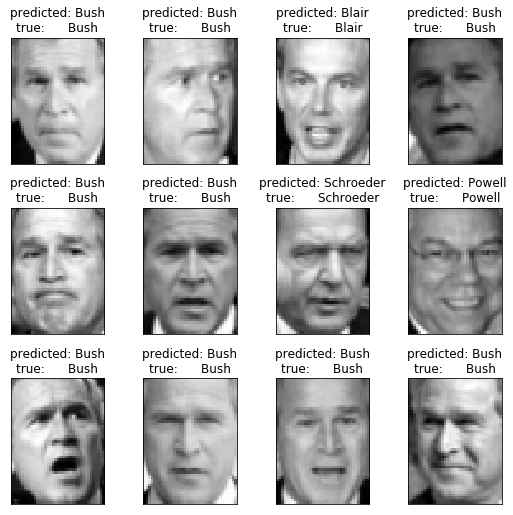

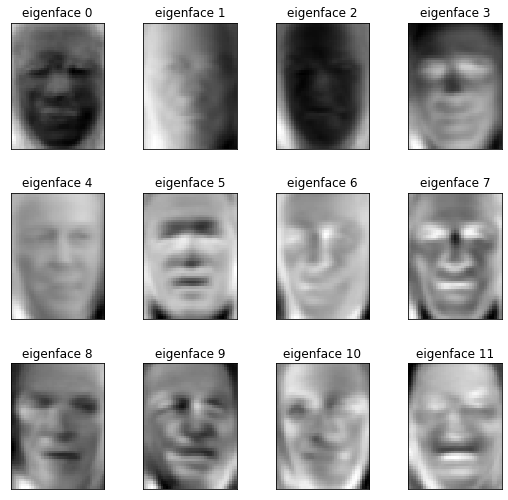

In [3]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(data_home = EXAMPLE_ROOT, download_if_missing = False, min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Custom predictions

In [14]:
from PIL import Image
import numpy as np

def recognize_face(face_name, face_id, face_preprocessed_number):
    plt.figure(figsize=(10, 10))
    
    im = Image.open(f'{LFW_FUNNELED}/{face_name}/{face_name}_{face_id}.jpg')
    plt.subplot(3, 1, 1)
    plt.imshow(im)
    
    plt.subplot(3, 1, 2)
    plt.imshow(lfw_people.images[face_preprocessed_number], cmap=plt.cm.gray)    
    
    face_data = []
    face_data.append(lfw_people.data[face_preprocessed_number])
    print(face_data)
    face_pca = pca.transform(face_data)
    
    face_pca_img = (face_pca * 255 / np.max(face_pca)).astype('uint8')
    face_pca_img = face_pca_img.reshape((15, 10))
    print(face_pca_img)
    plt.subplot(3, 1, 3)
    plt.imshow(face_pca_img, cmap=plt.cm.gray)
    
    prediction = clf.predict(face_pca)
    target_name = target_names[prediction]
    
    print(f'Predicted Value = {prediction}')
    print(f'Predicted Name = {target_name}')

# George W Bush

[array([ 89.333336, 104.      , 126.      , ..., 175.33333 , 183.33333 ,
       183.      ], dtype=float32)]
[[184 223  93 246 235 255  81 195  68 143]
 [191 179  21 140 245 253 187  49   3 161]
 [167 136 209 231  82  98 135 178  17  41]
 [176  73 130 123 238 127   3 252 156 133]
 [100  44 191 227 140 127  46 185 126  15]
 [184 234 228 109 140 173  97 236 187  16]
 [109 164 226 162 149 166  66 106 214  43]
 [230 207 181 182 176 161  59  13 246 247]
 [ 38  40 152  38  52  36 183   7 241 180]
 [ 33  68  57 218 184 151  79  88 144 140]
 [233  35  31  54 107  13 150 195  60 116]
 [166  73  27 154 169 246 106  29  79  64]
 [140 181 107 125 162 232 253 107  14 125]
 [178 167 149 106  53  64 253  43  49 188]
 [244 214  93  37 185 120  40 109  90  73]]
Predicted Value = [3]
Predicted Name = ['George W Bush']


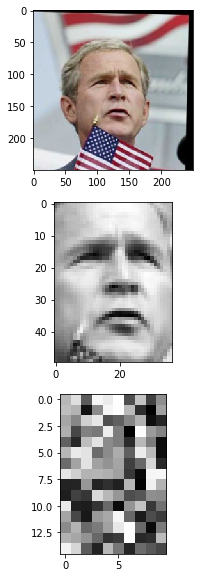

In [15]:
recognize_face('George_W_Bush', '0029', 2)

# Colin Powell

[array([16.666666 ,  7.6666665,  7.       , ..., 27.666666 , 38.       ,
       51.333332 ], dtype=float32)]
[[ 16 235 212 251   5 147  54  49 145  21]
 [161 243 153  29 210 148 182 197   7 254]
 [  0 122 178 101  26 207   0 226 243 204]
 [231  69  70 162 101 192 207 106  63 100]
 [ 45 164  91 228 174  30  17   7 250 127]
 [201 180 231 241  61 124  11 138 170 219]
 [ 68 165 124 228  99   0 255  18  93 230]
 [183 247 111  17 117 141 198  41  45 210]
 [185  20 103   3  94 195 207 243  44 233]
 [149 129  89  80 215  93 205  41 158  25]
 [ 58 153  63 245  53 140  55  84  27  26]
 [ 41 146  89  65  48 123 102 134  73  60]
 [ 62   8 101 112 199 160  49 176 122 249]
 [216 158  19  37  28 252 164 239 187 147]
 [192 206  39  89  19 150 174 123 126 140]]
Predicted Value = [1]
Predicted Name = ['Colin Powell']


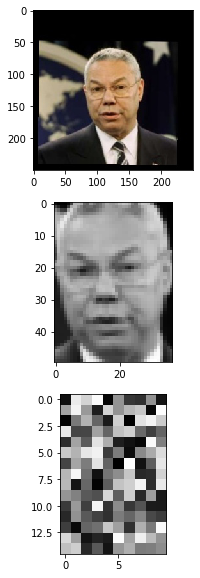

In [6]:
recognize_face('Colin_Powell', '0005', 3)

# Gerhard Schroeder

[array([24.333334, 29.333334, 62.333332, ..., 65.      , 30.666666,
       37.333332], dtype=float32)]
[[238 181   0 132  37  61 223 191  12 107]
 [ 84 141  19 238 234 142  17 136 184 254]
 [ 45  40  59   6  38  32 212  32 189 220]
 [254  59 122  80  51 134  58   0 185 254]
 [191 229  40  71 206  55 142  19 231 131]
 [ 53 227  69 151  57  12 231 226 216 152]
 [ 44 204 221 162  56   5  27  36 237 228]
 [168  26 192   2   3 179 175  48 219  96]
 [242 204 157  60  86 102  31  46 202 212]
 [238  18  53 182 127 188  10   0 253  97]
 [193 204  23 137  81 115  18  73 127  27]
 [ 44  14 197 104  66 253 250 244 174  58]
 [205  25  29 243 251 149 236  73  18 163]
 [ 12 240 227 244 150 175  98 240 255  72]
 [232 231  89  41  95  96 237 251 117  36]]
Predicted Value = [4]
Predicted Name = ['Gerhard Schroeder']


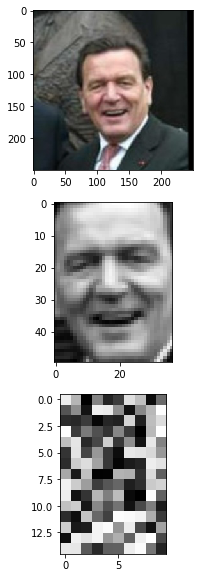

In [7]:
recognize_face('Gerhard_Schroeder', '0079', 7)